# **Method 2: Personalised Client Selection**
This method implements personalized client selection by dynamically adjusting selection probabilities to prioritize underperforming clients based on their probabilty, using the formula 1 - accuracy.

In [ ]:
!pip install flwr
!pip install torch
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.6/523.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.68.1
    Uninstalling grpcio-1.68.1:
      Successfully uninstalled grpcio-1.68.1
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1


In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import Necessary Libraries
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use "cuda" if GPU is available
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()


Training on cpu
Flower 1.14.0 / PyTorch 2.5.1+cu121


In [ ]:
NUM_CLIENTS = 10 # 10 Clients
BATCH_SIZE = 32

# Data Preprocessing
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):

        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create training and validation for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

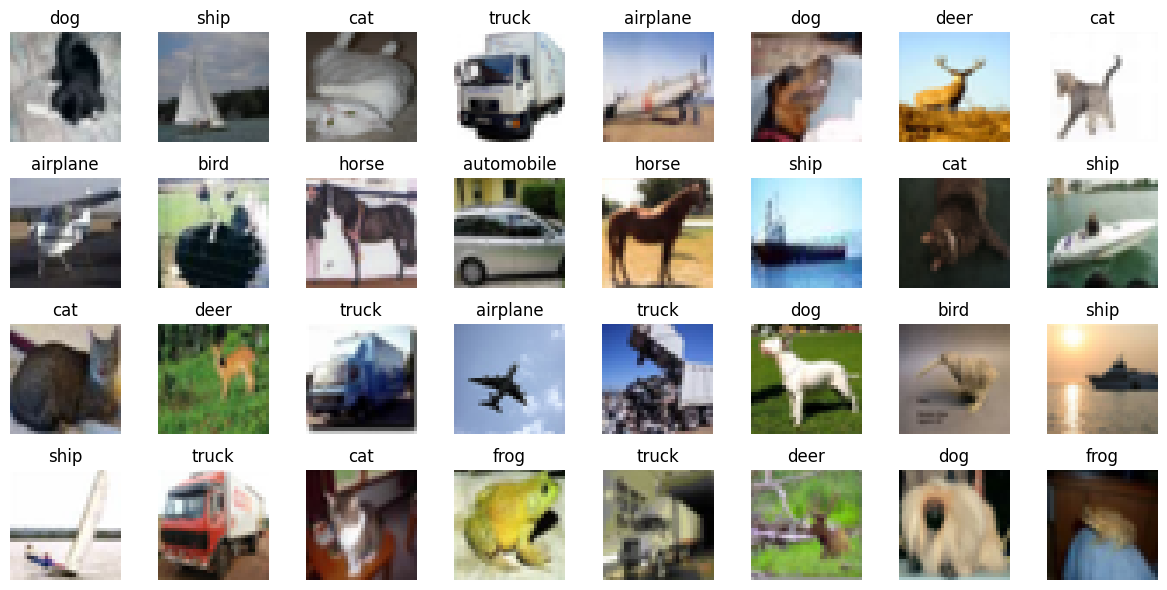

In [ ]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array

images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Plotting
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")


fig.tight_layout()
plt.show()

In [ ]:
# CNN Model for CIfar10
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Training Function for FL
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# testing function for FL
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(3):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.06060415053367615, accuracy 0.317
Epoch 2: validation loss 0.05511675465106964, accuracy 0.372
Epoch 3: validation loss 0.05297338628768921, accuracy 0.393
Final test set performance:
	loss 0.05318571298122406
	accuracy 0.3713


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# FlowerClient for FL
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> Client:

    # Load model
    net = Net().to(DEVICE)

    # Use client ID as partition ID
    partition_id = int(cid)
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)


In [ ]:
# Storing the accuracy of each client to use to compare
client_accuracies = {}

In [ ]:

from flwr.common import FitIns, Parameters
from flwr.server.client_proxy import ClientProxy

In [ ]:
from flwr.server.client_proxy import ClientProxy

In [ ]:
import random
import numpy as np
from typing import List, Tuple, Dict, Optional

from collections import OrderedDict
import flwr as fl
from flwr.server.strategy import FedAvg

from flwr.server.client_manager import ClientManager
from flwr.common import FitRes, EvaluateRes

class CustomFed(FedAvg):
    def __init__(self,
                 max_clients_per_round: int,
                 initial_clients: int,
                 **kwargs):

        super().__init__(**kwargs)
        self.max_clients_per_round = max_clients_per_round
        self.initial_clients = initial_clients
        self.client_accuracies: Dict[str, float] = {}
        self.metrics_distributed = {"accuracy": []}
        self.per_round_client_accuracies: List[Tuple[int, Dict[str, float]]] = []

    def configure_fit(
        self,
        server_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
    ) -> List[Tuple[ClientProxy, FitIns]]:
        available_clients = list(client_manager.all().values())

        if server_round == 1:
            # First round: select initial_clients (all 10)
            selected_clients = random.sample(available_clients, self.initial_clients)
            print(f"Round {server_round}: Initial selection - {[client.cid for client in selected_clients]}")
        else:
            # Subsequent rounds: select max_clients_per_round based on accuracies
            client_ids = [client.cid for client in available_clients]
            accuracies = np.array([self.client_accuracies.get(cid, 0.0) for cid in client_ids])

            # Assign higher probabilities to clients with lower accuracies
            probabilities = 1.0 - accuracies
            total_prob = probabilities.sum()
            if total_prob == 0:
                # All clients have perfect accuracy; select randomly
                probabilities = np.ones_like(probabilities) / len(probabilities)
            else:
                probabilities /= total_prob

            # Select clients based on the probabilities
            selected_indices = np.random.choice(
                len(available_clients),
                size=min(self.max_clients_per_round, len(available_clients)),
                replace=False,
                p=probabilities,
            )
            selected_clients = [available_clients[i] for i in selected_indices]
            print(f"Round {server_round}: Selected clients - {[client.cid for client in selected_clients]}")
            print(f"Round {server_round}: Selection probabilities {dict(zip(client_ids, probabilities.round(3)))}")

        # Creating fit instructions
        config = {}
        fit_ins = FitIns(parameters, config)
        return [(client, fit_ins) for client in selected_clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[BaseException],
    ) -> Optional[float]:
        # Update client accuracies based on evaluation results
        client_accuracies_round = {}
        for client_proxy, evaluate_res in results:
            cid = client_proxy.cid
            accuracy = evaluate_res.metrics.get("accuracy", 0.0)
            self.client_accuracies[cid] = accuracy
            client_accuracies_round[cid] = accuracy

        # Log client accuracies
        print(f"Round {server_round} client accuracies:")
        for cid, acc in client_accuracies_round.items():
            print(f"  Client {cid}: {acc:.4f}")

        # Store global accuracy for plotting
        aggregated_metrics = self.weighted_average([
            (evaluate_res.num_examples, evaluate_res.metrics)
            for _, evaluate_res in results
        ])
        global_accuracy = aggregated_metrics["accuracy"]
        self.metrics_distributed["accuracy"].append((server_round, global_accuracy))

        # Log global accuracy
        print(f"Round {server_round} aggregated accuracy: {global_accuracy:.4f}")

        # Proceed with default aggregation
        return super().aggregate_evaluate(server_round, results, failures)

    @staticmethod
    def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
        # Calculate weighted average of accuracy
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        if sum(examples) == 0:
            return {"accuracy": 0.0}
        return {"accuracy": sum(accuracies) / sum(examples)}


In [ ]:
# Parameters
NUM_CLIENTS = 10
NUM_ROUNDS = 20
INITIAL_CLIENTS = 10       # Number of clients in the first round
MAX_CLIENTS_PER_ROUND = 5  # Number of clients in subsequent rounds

# Initialize the custom strategy
strat = CustomFed(
    initial_clients=INITIAL_CLIENTS,
    max_clients_per_round=MAX_CLIENTS_PER_ROUND,
    fraction_fit=None,        # Manual selection handled within CustomFed
    min_fit_clients=MAX_CLIENTS_PER_ROUND,  # Ensure required number of clients
    min_available_clients=NUM_CLIENTS,
)


In [ ]:
# Create a ServerConfig with the number of rounds
server_config = fl.server.ServerConfig(num_rounds=NUM_ROUNDS)

# Start the simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    client_resources={"num_gpus": 1 if torch.cuda.is_available() else 0},
    config=server_config,
    strategy=strat,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
2024-12-30 12:58:47,240	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7992181556.0, 'object_store_memory': 3996090777.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
<ipython-input-25-c9769143fb03>:5: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  history = fl.s

Round 1: Initial selection - ['14656943721351270378', '11328203456813254640', '14062316243191917401', '8188015119929059214', '13342024845893171186', '13299779064864390030', '5701744137836691639', '12212311800043885350', '7768982508102151181', '14780859735314555225']


(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=16628) 
(ClientAppActor pid=16628)             This is a deprecated feature. It will be removed
(ClientAppActor pid=16628)             entirely in future versions of Flower.
(ClientAppActor pid=16628)         
(ClientAppActor pid=16627) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=16627) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=16627) see the appropriate new directories, set the environment variable
(ClientAppActor pid=16627) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=16627) The use of platformdir

Round 1 client accuracies:
  Client 5701744137836691639: 0.3090
  Client 14780859735314555225: 0.3520
  Client 13342024845893171186: 0.2980
  Client 14062316243191917401: 0.3080
  Client 7768982508102151181: 0.3150
  Client 8188015119929059214: 0.3420
  Client 11328203456813254640: 0.2990
  Client 13299779064864390030: 0.3420
  Client 14656943721351270378: 0.3270
  Client 12212311800043885350: 0.3440
Round 1 aggregated accuracy: 0.3236
Round 2: Selected clients - ['13299779064864390030', '14062316243191917401', '12212311800043885350', '8188015119929059214', '7768982508102151181']
Round 2: Selection probabilities {'13299779064864390030': 0.097, '7768982508102151181': 0.101, '14780859735314555225': 0.096, '11328203456813254640': 0.104, '12212311800043885350': 0.097, '5701744137836691639': 0.102, '14656943721351270378': 0.099, '8188015119929059214': 0.097, '14062316243191917401': 0.102, '13342024845893171186': 0.104}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=16627)          [repeated 12x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)         

Round 2 client accuracies:
  Client 7768982508102151181: 0.3790
  Client 14656943721351270378: 0.4000
  Client 13299779064864390030: 0.4320
  Client 14062316243191917401: 0.3610
  Client 11328203456813254640: 0.3560
  Client 14780859735314555225: 0.3980
  Client 8188015119929059214: 0.4200
  Client 12212311800043885350: 0.3870
  Client 13342024845893171186: 0.3580
  Client 5701744137836691639: 0.3670
Round 2 aggregated accuracy: 0.3858
Round 3: Selected clients - ['12212311800043885350', '7768982508102151181', '5701744137836691639', '14656943721351270378', '14780859735314555225']
Round 3: Selection probabilities {'13299779064864390030': 0.092, '7768982508102151181': 0.101, '14780859735314555225': 0.098, '11328203456813254640': 0.105, '12212311800043885350': 0.1, '5701744137836691639': 0.103, '14656943721351270378': 0.098, '8188015119929059214': 0.094, '14062316243191917401': 0.104, '13342024845893171186': 0.105}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)          

Round 3 client accuracies:
  Client 14062316243191917401: 0.4070
  Client 5701744137836691639: 0.4150
  Client 14780859735314555225: 0.4380
  Client 12212311800043885350: 0.4160
  Client 13299779064864390030: 0.4680
  Client 13342024845893171186: 0.4110
  Client 7768982508102151181: 0.4260
  Client 8188015119929059214: 0.4530
  Client 11328203456813254640: 0.4010
  Client 14656943721351270378: 0.4240
Round 3 aggregated accuracy: 0.4259
Round 4: Selected clients - ['8188015119929059214', '13299779064864390030', '12212311800043885350', '11328203456813254640', '13342024845893171186']
Round 4: Selection probabilities {'13299779064864390030': 0.093, '7768982508102151181': 0.1, '14780859735314555225': 0.098, '11328203456813254640': 0.104, '12212311800043885350': 0.102, '5701744137836691639': 0.102, '14656943721351270378': 0.1, '8188015119929059214': 0.095, '14062316243191917401': 0.103, '13342024845893171186': 0.103}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)          

Round 4 client accuracies:
  Client 14656943721351270378: 0.4370
  Client 8188015119929059214: 0.4830
  Client 7768982508102151181: 0.4380
  Client 14062316243191917401: 0.4370
  Client 5701744137836691639: 0.4360
  Client 13342024845893171186: 0.4300
  Client 13299779064864390030: 0.4570
  Client 11328203456813254640: 0.4250
  Client 12212311800043885350: 0.4360
  Client 14780859735314555225: 0.4490
Round 4 aggregated accuracy: 0.4428
Round 5: Selected clients - ['11328203456813254640', '7768982508102151181', '13342024845893171186', '14062316243191917401', '12212311800043885350']
Round 5: Selection probabilities {'13299779064864390030': 0.097, '7768982508102151181': 0.101, '14780859735314555225': 0.099, '11328203456813254640': 0.103, '12212311800043885350': 0.101, '5701744137836691639': 0.101, '14656943721351270378': 0.101, '8188015119929059214': 0.093, '14062316243191917401': 0.101, '13342024845893171186': 0.102}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16628)          [repeated 4x across cluster]
(ClientAppActor pid=16628)          

Round 5 client accuracies:
  Client 7768982508102151181: 0.4490
  Client 12212311800043885350: 0.4490
  Client 14656943721351270378: 0.4480
  Client 11328203456813254640: 0.4510
  Client 14780859735314555225: 0.4760
  Client 8188015119929059214: 0.4820
  Client 5701744137836691639: 0.4490
  Client 14062316243191917401: 0.4380
  Client 13342024845893171186: 0.4490
  Client 13299779064864390030: 0.4720
Round 5 aggregated accuracy: 0.4563
Round 6: Selected clients - ['13299779064864390030', '5701744137836691639', '7768982508102151181', '13342024845893171186', '14656943721351270378']
Round 6: Selection probabilities {'13299779064864390030': 0.097, '7768982508102151181': 0.101, '14780859735314555225': 0.096, '11328203456813254640': 0.101, '12212311800043885350': 0.101, '5701744137836691639': 0.101, '14656943721351270378': 0.102, '8188015119929059214': 0.095, '14062316243191917401': 0.103, '13342024845893171186': 0.101}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=16627)          [repeated 10x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)         

Round 6 client accuracies:
  Client 12212311800043885350: 0.4490
  Client 11328203456813254640: 0.4530
  Client 5701744137836691639: 0.4580
  Client 13342024845893171186: 0.4560
  Client 8188015119929059214: 0.5000
  Client 14656943721351270378: 0.4750
  Client 14780859735314555225: 0.5060
  Client 14062316243191917401: 0.4580
  Client 7768982508102151181: 0.4580
  Client 13299779064864390030: 0.4760
Round 6 aggregated accuracy: 0.4689
Round 7: Selected clients - ['7768982508102151181', '11328203456813254640', '14656943721351270378', '14780859735314555225', '12212311800043885350']
Round 7: Selection probabilities {'13299779064864390030': 0.099, '7768982508102151181': 0.102, '14780859735314555225': 0.093, '11328203456813254640': 0.103, '12212311800043885350': 0.104, '5701744137836691639': 0.102, '14656943721351270378': 0.099, '8188015119929059214': 0.094, '14062316243191917401': 0.102, '13342024845893171186': 0.102}


(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16628)          [repeated 8x across cluster]
(ClientAppActor pid=16628)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16628)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16628)          [repeated 4x across cluster]
(ClientAppActor pid=16628)          

Round 7 client accuracies:
  Client 14062316243191917401: 0.4730
  Client 14780859735314555225: 0.5140
  Client 13342024845893171186: 0.4720
  Client 11328203456813254640: 0.4670
  Client 5701744137836691639: 0.4780
  Client 12212311800043885350: 0.4790
  Client 7768982508102151181: 0.4820
  Client 13299779064864390030: 0.5080
  Client 14656943721351270378: 0.5000
  Client 8188015119929059214: 0.5050
Round 7 aggregated accuracy: 0.4878
Round 8: Selected clients - ['13342024845893171186', '12212311800043885350', '13299779064864390030', '8188015119929059214', '5701744137836691639']
Round 8: Selection probabilities {'13299779064864390030': 0.096, '7768982508102151181': 0.101, '14780859735314555225': 0.095, '11328203456813254640': 0.104, '12212311800043885350': 0.102, '5701744137836691639': 0.102, '14656943721351270378': 0.098, '8188015119929059214': 0.097, '14062316243191917401': 0.103, '13342024845893171186': 0.103}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)          

Round 8 client accuracies:
  Client 11328203456813254640: 0.4770
  Client 14656943721351270378: 0.4900
  Client 14780859735314555225: 0.5200
  Client 14062316243191917401: 0.4810
  Client 12212311800043885350: 0.4810
  Client 13299779064864390030: 0.5140
  Client 13342024845893171186: 0.4860
  Client 8188015119929059214: 0.5210
  Client 5701744137836691639: 0.4830
  Client 7768982508102151181: 0.4890
Round 8 aggregated accuracy: 0.4942
Round 9: Selected clients - ['13299779064864390030', '14780859735314555225', '14062316243191917401', '5701744137836691639', '14656943721351270378']
Round 9: Selection probabilities {'13299779064864390030': 0.096, '7768982508102151181': 0.101, '14780859735314555225': 0.095, '11328203456813254640': 0.103, '12212311800043885350': 0.103, '5701744137836691639': 0.102, '14656943721351270378': 0.101, '8188015119929059214': 0.095, '14062316243191917401': 0.103, '13342024845893171186': 0.102}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)          

Round 9 client accuracies:
  Client 7768982508102151181: 0.4840
  Client 14062316243191917401: 0.4990
  Client 11328203456813254640: 0.4760
  Client 12212311800043885350: 0.4770
  Client 14780859735314555225: 0.5260
  Client 13342024845893171186: 0.4860
  Client 8188015119929059214: 0.5060
  Client 14656943721351270378: 0.4920
  Client 5701744137836691639: 0.4850
  Client 13299779064864390030: 0.5170
Round 9 aggregated accuracy: 0.4948
Round 10: Selected clients - ['14780859735314555225', '5701744137836691639', '7768982508102151181', '14656943721351270378', '13299779064864390030']
Round 10: Selection probabilities {'13299779064864390030': 0.096, '7768982508102151181': 0.102, '14780859735314555225': 0.094, '11328203456813254640': 0.104, '12212311800043885350': 0.104, '5701744137836691639': 0.102, '14656943721351270378': 0.101, '8188015119929059214': 0.098, '14062316243191917401': 0.099, '13342024845893171186': 0.102}


(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16628)          [repeated 8x across cluster]
(ClientAppActor pid=16628)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16628)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16628)          [repeated 4x across cluster]
(ClientAppActor pid=16628)          

Round 10 client accuracies:
  Client 14780859735314555225: 0.5340
  Client 5701744137836691639: 0.4970
  Client 13342024845893171186: 0.4890
  Client 7768982508102151181: 0.4980
  Client 14656943721351270378: 0.4960
  Client 8188015119929059214: 0.5200
  Client 14062316243191917401: 0.4970
  Client 11328203456813254640: 0.4740
  Client 12212311800043885350: 0.4820
  Client 13299779064864390030: 0.5300
Round 10 aggregated accuracy: 0.5017
Round 11: Selected clients - ['7768982508102151181', '5701744137836691639', '12212311800043885350', '14062316243191917401', '13299779064864390030']
Round 11: Selection probabilities {'13299779064864390030': 0.094, '7768982508102151181': 0.101, '14780859735314555225': 0.094, '11328203456813254640': 0.106, '12212311800043885350': 0.104, '5701744137836691639': 0.101, '14656943721351270378': 0.101, '8188015119929059214': 0.096, '14062316243191917401': 0.101, '13342024845893171186': 0.103}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16628)          [repeated 4x across cluster]
(ClientAppActor pid=16628)          

Round 11 client accuracies:
  Client 8188015119929059214: 0.5520
  Client 5701744137836691639: 0.4890
  Client 11328203456813254640: 0.4890
  Client 14780859735314555225: 0.5440
  Client 14062316243191917401: 0.5170
  Client 13342024845893171186: 0.5070
  Client 14656943721351270378: 0.5260
  Client 7768982508102151181: 0.5010
  Client 12212311800043885350: 0.4850
  Client 13299779064864390030: 0.5350
Round 11 aggregated accuracy: 0.5145
Round 12: Selected clients - ['8188015119929059214', '11328203456813254640', '5701744137836691639', '12212311800043885350', '7768982508102151181']
Round 12: Selection probabilities {'13299779064864390030': 0.096, '7768982508102151181': 0.103, '14780859735314555225': 0.094, '11328203456813254640': 0.105, '12212311800043885350': 0.106, '5701744137836691639': 0.105, '14656943721351270378': 0.098, '8188015119929059214': 0.092, '14062316243191917401': 0.099, '13342024845893171186': 0.102}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=16627)          [repeated 10x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16628)          [repeated 4x across cluster]
(ClientAppActor pid=16628)         

Round 12 client accuracies:
  Client 12212311800043885350: 0.5200
  Client 14780859735314555225: 0.5640
  Client 7768982508102151181: 0.5230
  Client 14062316243191917401: 0.5190
  Client 8188015119929059214: 0.5510
  Client 14656943721351270378: 0.5330
  Client 13299779064864390030: 0.5450
  Client 11328203456813254640: 0.5070
  Client 13342024845893171186: 0.5130
  Client 5701744137836691639: 0.5160
Round 12 aggregated accuracy: 0.5291
Round 13: Selected clients - ['13342024845893171186', '14780859735314555225', '7768982508102151181', '11328203456813254640', '13299779064864390030']
Round 13: Selection probabilities {'13299779064864390030': 0.097, '7768982508102151181': 0.101, '14780859735314555225': 0.093, '11328203456813254640': 0.105, '12212311800043885350': 0.102, '5701744137836691639': 0.103, '14656943721351270378': 0.099, '8188015119929059214': 0.095, '14062316243191917401': 0.102, '13342024845893171186': 0.103}


(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627)          

Round 13 client accuracies:
  Client 5701744137836691639: 0.5100
  Client 7768982508102151181: 0.5350
  Client 14062316243191917401: 0.5350
  Client 14780859735314555225: 0.5690
  Client 14656943721351270378: 0.5310
  Client 8188015119929059214: 0.5470
  Client 13342024845893171186: 0.5010
  Client 13299779064864390030: 0.5390
  Client 11328203456813254640: 0.5200
  Client 12212311800043885350: 0.5160
Round 13 aggregated accuracy: 0.5303
Round 14: Selected clients - ['13342024845893171186', '14062316243191917401', '14780859735314555225', '14656943721351270378', '5701744137836691639']
Round 14: Selection probabilities {'13299779064864390030': 0.098, '7768982508102151181': 0.099, '14780859735314555225': 0.092, '11328203456813254640': 0.102, '12212311800043885350': 0.103, '5701744137836691639': 0.104, '14656943721351270378': 0.1, '8188015119929059214': 0.096, '14062316243191917401': 0.099, '13342024845893171186': 0.106}


(ClientAppActor pid=16628)          [repeated 12x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=16628)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=16628)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=16628)          [repeated 4x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16628)         

Round 14 client accuracies:
  Client 13342024845893171186: 0.5200
  Client 14656943721351270378: 0.5350
  Client 12212311800043885350: 0.5270
  Client 14780859735314555225: 0.5770
  Client 5701744137836691639: 0.5240
  Client 11328203456813254640: 0.5200
  Client 7768982508102151181: 0.5420
  Client 13299779064864390030: 0.5530
  Client 14062316243191917401: 0.5520
  Client 8188015119929059214: 0.5580
Round 14 aggregated accuracy: 0.5408
Round 15: Selected clients - ['14656943721351270378', '5701744137836691639', '12212311800043885350', '14062316243191917401', '8188015119929059214']
Round 15: Selection probabilities {'13299779064864390030': 0.097, '7768982508102151181': 0.1, '14780859735314555225': 0.092, '11328203456813254640': 0.105, '12212311800043885350': 0.103, '5701744137836691639': 0.104, '14656943721351270378': 0.101, '8188015119929059214': 0.096, '14062316243191917401': 0.098, '13342024845893171186': 0.105}


(ClientAppActor pid=16627)          [repeated 12x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)         

Round 15 client accuracies:
  Client 13299779064864390030: 0.5650
  Client 8188015119929059214: 0.5660
  Client 5701744137836691639: 0.5220
  Client 12212311800043885350: 0.5200
  Client 14062316243191917401: 0.5500
  Client 14780859735314555225: 0.5870
  Client 14656943721351270378: 0.5490
  Client 7768982508102151181: 0.5270
  Client 13342024845893171186: 0.5160
  Client 11328203456813254640: 0.5210
Round 15 aggregated accuracy: 0.5423
Round 16: Selected clients - ['12212311800043885350', '11328203456813254640', '8188015119929059214', '7768982508102151181', '14062316243191917401']
Round 16: Selection probabilities {'13299779064864390030': 0.095, '7768982508102151181': 0.103, '14780859735314555225': 0.09, '11328203456813254640': 0.105, '12212311800043885350': 0.105, '5701744137836691639': 0.104, '14656943721351270378': 0.099, '8188015119929059214': 0.095, '14062316243191917401': 0.098, '13342024845893171186': 0.106}


(ClientAppActor pid=16627)          [repeated 12x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)         

Round 16 client accuracies:
  Client 14062316243191917401: 0.5610
  Client 12212311800043885350: 0.5280
  Client 7768982508102151181: 0.5470
  Client 8188015119929059214: 0.5700
  Client 13299779064864390030: 0.5630
  Client 14656943721351270378: 0.5460
  Client 11328203456813254640: 0.5260
  Client 5701744137836691639: 0.5390
  Client 13342024845893171186: 0.5290
  Client 14780859735314555225: 0.5750
Round 16 aggregated accuracy: 0.5484
Round 17: Selected clients - ['14780859735314555225', '14656943721351270378', '8188015119929059214', '13299779064864390030', '7768982508102151181']
Round 17: Selection probabilities {'13299779064864390030': 0.097, '7768982508102151181': 0.1, '14780859735314555225': 0.094, '11328203456813254640': 0.105, '12212311800043885350': 0.105, '5701744137836691639': 0.102, '14656943721351270378': 0.101, '8188015119929059214': 0.095, '14062316243191917401': 0.097, '13342024845893171186': 0.104}


(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          

Round 17 client accuracies:
  Client 11328203456813254640: 0.5420
  Client 5701744137836691639: 0.5330
  Client 8188015119929059214: 0.5840
  Client 12212311800043885350: 0.5260
  Client 14062316243191917401: 0.5680
  Client 13299779064864390030: 0.5780
  Client 14656943721351270378: 0.5640
  Client 7768982508102151181: 0.5380
  Client 14780859735314555225: 0.5880
  Client 13342024845893171186: 0.5220
Round 17 aggregated accuracy: 0.5543
Round 18: Selected clients - ['13342024845893171186', '8188015119929059214', '14062316243191917401', '14780859735314555225', '7768982508102151181']
Round 18: Selection probabilities {'13299779064864390030': 0.095, '7768982508102151181': 0.104, '14780859735314555225': 0.092, '11328203456813254640': 0.103, '12212311800043885350': 0.106, '5701744137836691639': 0.105, '14656943721351270378': 0.098, '8188015119929059214': 0.093, '14062316243191917401': 0.097, '13342024845893171186': 0.107}


(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          

Round 18 client accuracies:
  Client 14656943721351270378: 0.5630
  Client 11328203456813254640: 0.5460
  Client 14780859735314555225: 0.5840
  Client 7768982508102151181: 0.5540
  Client 13299779064864390030: 0.5780
  Client 8188015119929059214: 0.5780
  Client 5701744137836691639: 0.5450
  Client 14062316243191917401: 0.5710
  Client 13342024845893171186: 0.5200
  Client 12212311800043885350: 0.5430
Round 18 aggregated accuracy: 0.5582
Round 19: Selected clients - ['14062316243191917401', '7768982508102151181', '14656943721351270378', '14780859735314555225', '13342024845893171186']
Round 19: Selection probabilities {'13299779064864390030': 0.096, '7768982508102151181': 0.101, '14780859735314555225': 0.094, '11328203456813254640': 0.103, '12212311800043885350': 0.103, '5701744137836691639': 0.103, '14656943721351270378': 0.099, '8188015119929059214': 0.096, '14062316243191917401': 0.097, '13342024845893171186': 0.109}


(ClientAppActor pid=16627)          [repeated 8x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16627)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16627)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          

Round 19 client accuracies:
  Client 14780859735314555225: 0.5860
  Client 11328203456813254640: 0.5440
  Client 7768982508102151181: 0.5640
  Client 8188015119929059214: 0.5860
  Client 13342024845893171186: 0.5300
  Client 14062316243191917401: 0.5770
  Client 5701744137836691639: 0.5490
  Client 13299779064864390030: 0.5860
  Client 12212311800043885350: 0.5340
  Client 14656943721351270378: 0.5640
Round 19 aggregated accuracy: 0.5620
Round 20: Selected clients - ['7768982508102151181', '14780859735314555225', '5701744137836691639', '11328203456813254640', '14656943721351270378']
Round 20: Selection probabilities {'13299779064864390030': 0.095, '7768982508102151181': 0.1, '14780859735314555225': 0.095, '11328203456813254640': 0.104, '12212311800043885350': 0.106, '5701744137836691639': 0.103, '14656943721351270378': 0.1, '8188015119929059214': 0.095, '14062316243191917401': 0.097, '13342024845893171186': 0.107}


(ClientAppActor pid=16628)          [repeated 8x across cluster]
(ClientAppActor pid=16628) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=16628)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=16628)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=16627)          [repeated 4x across cluster]
(ClientAppActor pid=16627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=16627)          

Round 20 client accuracies:
  Client 13299779064864390030: 0.5800
  Client 13342024845893171186: 0.5350
  Client 5701744137836691639: 0.5500
  Client 14656943721351270378: 0.5670
  Client 12212311800043885350: 0.5520
  Client 8188015119929059214: 0.5860
  Client 14780859735314555225: 0.5950
  Client 11328203456813254640: 0.5670
  Client 7768982508102151181: 0.5660
  Client 14062316243191917401: 0.5800
Round 20 aggregated accuracy: 0.5678


Uniform selection for comparing with the personalised selection

In [ ]:
import flwr as fl
from flwr.server.strategy import FedAvg
from flwr.common import (
    FitIns,
    FitRes,
    EvaluateRes,
    Parameters,
    Scalar,
    Config,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from typing import List, Tuple, Dict, Optional

class FedAvgWithParams(FedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.latest_parameters: Optional[Parameters] = None  # To store the latest global parameters
        self.metrics_distributed = {"accuracy": []}         # Store global accuracy over rounds

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[BaseException],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            # Store the latest global parameters
            self.latest_parameters = aggregated_parameters
        return aggregated_parameters, aggregated_metrics

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[BaseException],
    ) -> Optional[float]:

        metrics = []
        for client_proxy, evaluate_res in results:
            num_examples = evaluate_res.num_examples
            accuracy = evaluate_res.metrics.get("accuracy", 0.0)
            metrics.append((num_examples, {"accuracy": accuracy}))
        # Compute weighted average accuracy
        aggregated_metrics = self.weighted_average(metrics)
        global_accuracy = aggregated_metrics["accuracy"]
        # Store global accuracy for plotting
        self.metrics_distributed["accuracy"].append((server_round, global_accuracy))
        # Log the global accuracy
        print(f"Round {server_round} aggregated accuracy: {global_accuracy}")
        # Proceed with default aggregation
        return super().aggregate_evaluate(server_round, results, failures)

    @staticmethod
    def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
        # Calculate weighted average of accuracy
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        if sum(examples) == 0:
            return {"accuracy": 0.0}
        return {"accuracy": sum(accuracies) / sum(examples)}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

NUM_ROUNDS = 20  # Train the FL model for 20 rounds
LOCAL_EPOCHS = 1  # Number of local epochs per client

# Update the client function to use LOCAL_EPOCHS
def client_fn(cid: str) -> fl.client.Client:
    """Create a Flower client with the given client ID."""
    # Load model
    net = Net().to(DEVICE)


    partition_id = int(cid)
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create the Flower client and convert it to `Client`
    return FlowerClient(net, trainloader, valloader).to_client()

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config: Config) -> List[np.ndarray]:
        return get_parameters(self.net)

    def fit(self, parameters: List[np.ndarray], config: Config) -> Tuple[List[np.ndarray], int, Dict]:
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=LOCAL_EPOCHS)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters: List[np.ndarray], config: Config) -> Tuple[float, int, Dict]:
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

# Initialize the standard FedAvg strategy with parameter storage
standard_strategy = FedAvgWithParams(
    fraction_fit=1.0,         # m/N = 5/10 = 0.5
    min_fit_clients=10,        # Ensure at least 5 clients are selected
    min_available_clients=NUM_CLIENTS,
)

# Create a ServerConfig with the number of rounds
server_config = fl.server.ServerConfig(num_rounds=NUM_ROUNDS)

# Start the simulation with the standard strategy
history_standard = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    client_resources={"num_gpus": 1 if torch.cuda.is_available() else 0},
    config=server_config,
    strategy=standard_strategy,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
2024-12-30 12:42:30,500	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7990628352.0, 'object_store_memory': 3995314176.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
<ipython-input-18-8358088e5277>:48: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  history_stand

Round 1 aggregated accuracy: 0.3052


(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949)             Thi

Round 2 aggregated accuracy: 0.3551


(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8947)          [repeated 4x across cluster]
(ClientAppActor pid=8947)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=8947)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949)             This

Round 3 aggregated accuracy: 0.398


(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949)             Thi

Round 4 aggregated accuracy: 0.4246


(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949)             Thi

Round 5 aggregated accuracy: 0.4453


(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=8947)          [repeated 6x across cluster]
(ClientAppActor pid=8947)             This

Round 6 aggregated accuracy: 0.4569


(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This

Round 7 aggregated accuracy: 0.4776


(ClientAppActor pid=8947)          [repeated 12x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8947)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8947)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8947)          [repeated 4x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8947)             Thi

Round 8 aggregated accuracy: 0.4865


(ClientAppActor pid=8947)          [repeated 12x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8947)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8947)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             Thi

Round 9 aggregated accuracy: 0.496


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8947)          [repeated 4x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8947)             Thi

Round 10 aggregated accuracy: 0.5092


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             Thi

Round 11 aggregated accuracy: 0.5139


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             Thi

Round 12 aggregated accuracy: 0.5203


(ClientAppActor pid=8947)          [repeated 12x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8947)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8947)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             Thi

Round 13 aggregated accuracy: 0.5287


(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This

Round 14 aggregated accuracy: 0.5361


(ClientAppActor pid=8949)          [repeated 8x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This

Round 15 aggregated accuracy: 0.5403


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8947)          [repeated 4x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8947)             Thi

Round 16 aggregated accuracy: 0.5454


(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             This

Round 17 aggregated accuracy: 0.5543


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             Thi

Round 18 aggregated accuracy: 0.5624


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8949)          [repeated 4x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8949)             Thi

Round 19 aggregated accuracy: 0.5696


(ClientAppActor pid=8949)          [repeated 12x across cluster]
(ClientAppActor pid=8949) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=8949)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=8949)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=8947)          [repeated 4x across cluster]
(ClientAppActor pid=8947) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=8947)             Thi

Round 20 aggregated accuracy: 0.5731


In [ ]:
# Retrieve the final global parameters from the standard strategy
final_parameters_standard = standard_strategy.latest_parameters

# Load the global test set
_, _, testloader = load_datasets(partition_id=0)  # The test set is the same for all

# Define the evaluation function if not already defined
def evaluate_global_model(global_parameters: Parameters, testloader):

    params = fl.common.parameters_to_ndarrays(global_parameters)

    # Initialize a new model instance
    net = Net().to(DEVICE)

    # Set the model parameters to the global parameters
    set_parameters(net, params)

    # Evaluate on the test set
    loss, accuracy = test(net, testloader)
    return loss, accuracy

# Evaluate the final global model after uniform selection
loss_standard, accuracy_standard = evaluate_global_model(final_parameters_standard, testloader)

# Print the evaluation results
print(f"Final test set performance after uniform selection:")
print(f"\tLoss: {loss_standard}")
print(f"\tAccuracy: {accuracy_standard}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final test set performance after uniform selection:
	Loss: 0.037509450006484986
	Accuracy: 0.5718


Visualisation to compare Uniform Selection with Personalised client selection

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


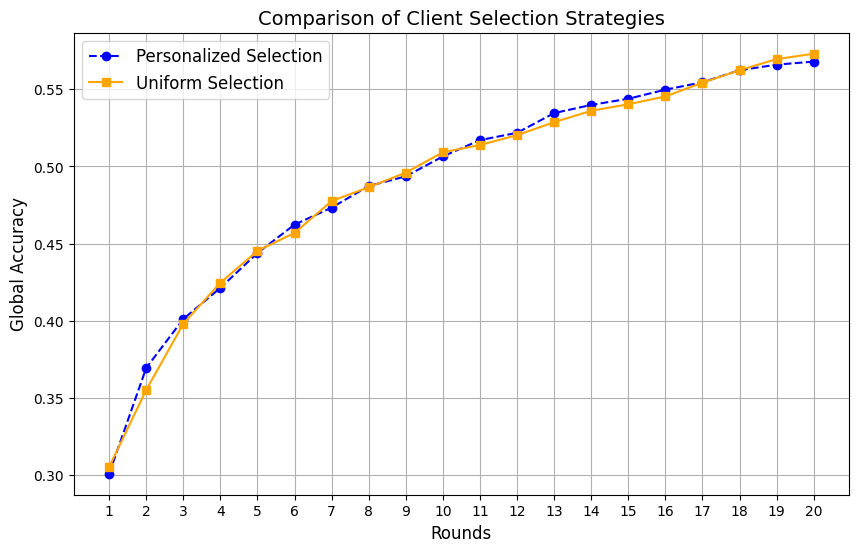

In [ ]:
import matplotlib.pyplot as plt

# Visualization function
def plot_accuracies(personalized_strategy, uniform_strategy):

    # Extract rounds and accuracies from strategies
    personalized_data = personalized_strategy.metrics_distributed["accuracy"]
    uniform_data = uniform_strategy.metrics_distributed["accuracy"]

    if not personalized_data or not uniform_data:
        print("No accuracy data available. Ensure you have run your FL simulations.")
        return

    # Extract rounds and accuracies for both strategies
    personalized_rounds, personalized_accuracies = zip(*personalized_data)
    uniform_rounds, uniform_accuracies = zip(*uniform_data)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(personalized_rounds, personalized_accuracies, label="Personalized Selection", marker='o', linestyle='--', color='blue')
    plt.plot(uniform_rounds, uniform_accuracies, label="Uniform Selection", marker='s', linestyle='-', color='orange')

    # Customize the plot
    plt.title("Comparison of Client Selection Strategies", fontsize=14)
    plt.xlabel("Rounds", fontsize=12)
    plt.ylabel("Global Accuracy", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(range(1, max(personalized_rounds) + 1))
    plt.show()


# Plotting
plot_accuracies(strat, standard_strategy)
